In [1]:
import geopandas as gpd
import rasterio
from shapely.geometry import box, Point
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import starmap
import requests
import zipfile
import io
import boto3
from tqdm import tqdm
from rasterio.crs import CRS

from dem_stitcher.geojson_io import to_geojson_gzip
from dem_stitcher.datasets import DATA_PATH
from dem_stitcher.dem_readers import read_srtm

# SRTM

From here: https://figshare.com/articles/dataset/Vector_grid_of_SRTM_1x1_degree_tiles/1332753

In [2]:
df_srtm_raw = gpd.read_file('https://ndownloader.figshare.com/files/1944795')
df_srtm_raw.head()

,id,geometry
0,N00E006,"POLYGON ((6.00000 0.00000, 6.00000 1.00000, 7...."
1,N00E009,"POLYGON ((9.00000 0.00000, 9.00000 1.00000, 10..."
2,N00E010,"POLYGON ((10.00000 0.00000, 10.00000 1.00000, ..."
3,N00E011,"POLYGON ((11.00000 0.00000, 11.00000 1.00000, ..."
4,N00E012,"POLYGON ((12.00000 0.00000, 12.00000 1.00000, ..."


In [3]:
df_srtm = df_srtm_raw.copy()
df_srtm.rename(columns={'id': 'tile_id'}, inplace=True)
df_srtm['url'] = df_srtm['tile_id'].map(lambda tile_id: f'http://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.003/2000.02.11/{tile_id}.SRTMGL1.hgt.zip')
df_srtm = df_srtm[['tile_id', 'url', 'geometry']].copy()
df_srtm.head()

,tile_id,url,geometry
0,N00E006,http://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.00...,"POLYGON ((6.00000 0.00000, 6.00000 1.00000, 7...."
1,N00E009,http://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.00...,"POLYGON ((9.00000 0.00000, 9.00000 1.00000, 10..."
2,N00E010,http://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.00...,"POLYGON ((10.00000 0.00000, 10.00000 1.00000, ..."
3,N00E011,http://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.00...,"POLYGON ((11.00000 0.00000, 11.00000 1.00000, ..."
4,N00E012,http://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.00...,"POLYGON ((12.00000 0.00000, 12.00000 1.00000, ..."


In [4]:
to_geojson_gzip(df_srtm, DATA_PATH/'srtm_v3.geojson.zip')

PosixPath('/Users/cmarshak/bekaert-team/dem-stitcher/dem_stitcher/data/srtm_v3.geojson.zip')

In [5]:
urls = df_srtm.url.to_list()

X, p = read_srtm(urls[0])

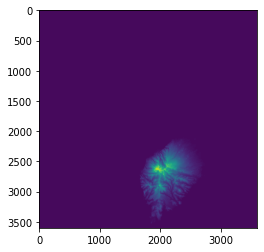

In [6]:
plt.imshow(X)

# TDX

In [7]:
df_tdx_raw = gpd.read_file('https://copernicus-dem-30m.s3.amazonaws.com/grid.zip')
df_tdx_raw.head()

,id,geometry
0,Copernicus_DSM_COG_10_N85_00_W180_00_DEM,"POLYGON ((-180.001 85.000, -180.001 86.000, -1..."
1,Copernicus_DSM_COG_10_N85_00_W179_00_DEM,"POLYGON ((-179.001 85.000, -179.001 86.000, -1..."
2,Copernicus_DSM_COG_10_N85_00_W178_00_DEM,"POLYGON ((-178.001 85.000, -178.001 86.000, -1..."
3,Copernicus_DSM_COG_10_N85_00_W177_00_DEM,"POLYGON ((-177.001 85.000, -177.001 86.000, -1..."
4,Copernicus_DSM_COG_10_N85_00_W176_00_DEM,"POLYGON ((-176.001 85.000, -176.001 86.000, -1..."


In [8]:
df_tdx = df_tdx_raw.copy()

In [9]:
df_tdx.rename(columns={'id': 'tile_id'}, inplace=True)
TDX_URL = 'https://copernicus-dem-30m.s3.amazonaws.com'
df_tdx['url'] = df_tdx['tile_id'].map(lambda tile_id: f'{TDX_URL}/{tile_id}/{tile_id}.tif')
df_tdx = df_tdx[['tile_id', 'url', 'geometry']]

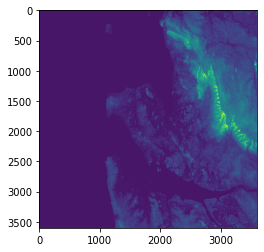

In [10]:
urls = df_tdx.url.tolist()
k = 32589

with rasterio.open(urls[k]) as ds:
    X = ds.read(1)
plt.imshow(X)

In [11]:
to_geojson_gzip(df_tdx, DATA_PATH/'tdx_30.geojson.zip')

PosixPath('/Users/cmarshak/bekaert-team/dem-stitcher/dem_stitcher/data/tdx_30.geojson.zip')

# 3dep

## Read through S3 Bucket

In [12]:
s3client = boto3.client('s3')
BUCKET_NAME = 'prd-tnm'
objects = s3client.list_objects(Bucket=BUCKET_NAME,
                                Prefix='StagedProducts/Elevation/1/TIFF/')
objects['Contents'][:5]

[{'Key': 'StagedProducts/Elevation/1/TIFF/n06e162/USGS_1_n06e162.jpg',
  'LastModified': datetime.datetime(2019, 12, 4, 2, 16, 38, tzinfo=tzutc()),
  'ETag': '"3ccc340f6c4664b0183267239f40cf6e"',
  'Size': 969,
  'StorageClass': 'STANDARD'},
 {'Key': 'StagedProducts/Elevation/1/TIFF/n06e162/USGS_1_n06e162.tif',
  'LastModified': datetime.datetime(2019, 12, 11, 2, 16, 43, tzinfo=tzutc()),
  'ETag': '"90d8ba82df12261245aa09cbbaf22589"',
  'Size': 1542700,
  'StorageClass': 'STANDARD'},
 {'Key': 'StagedProducts/Elevation/1/TIFF/n06e162/USGS_1_n06e162.xml',
  'LastModified': datetime.datetime(2019, 12, 4, 2, 16, 38, tzinfo=tzutc()),
  'ETag': '"5fe5e0cc9932d4bd9413d1482047977a"',
  'Size': 11221,
  'StorageClass': 'STANDARD'},
 {'Key': 'StagedProducts/Elevation/1/TIFF/n06e162/n06e162.gpkg',
  'LastModified': datetime.datetime(2019, 12, 6, 2, 17, 1, tzinfo=tzutc()),
  'ETag': '"c60495b0dcba350365514933a716d586"',
  'Size': 98304,
  'StorageClass': 'STANDARD'},
 {'Key': 'StagedProducts/Eleva

In [13]:
paginator = s3client.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=BUCKET_NAME, 
                           Prefix='StagedProducts/Elevation/1/TIFF/')

In [14]:
all_contents = []
for page in tqdm(pages):
    all_contents += page['Contents']

all_contents[0]

17it [00:13,  1.23it/s]


{'Key': 'StagedProducts/Elevation/1/TIFF/n06e162/USGS_1_n06e162.jpg',
 'LastModified': datetime.datetime(2019, 12, 4, 2, 16, 38, tzinfo=tzutc()),
 'ETag': '"3ccc340f6c4664b0183267239f40cf6e"',
 'Size': 969,
 'StorageClass': 'STANDARD'}

In [15]:
tif_obs = list(filter(lambda ob: '.tif' in ob['Key'], all_contents))
tif_obs[:3]

[{'Key': 'StagedProducts/Elevation/1/TIFF/n06e162/USGS_1_n06e162.tif',
  'LastModified': datetime.datetime(2019, 12, 11, 2, 16, 43, tzinfo=tzutc()),
  'ETag': '"90d8ba82df12261245aa09cbbaf22589"',
  'Size': 1542700,
  'StorageClass': 'STANDARD'},
 {'Key': 'StagedProducts/Elevation/1/TIFF/n06e163/USGS_1_n06e163.tif',
  'LastModified': datetime.datetime(2019, 12, 11, 2, 16, 43, tzinfo=tzutc()),
  'ETag': '"f2799568910a5217bafdcc6f122d5729"',
  'Size': 1253435,
  'StorageClass': 'STANDARD'},
 {'Key': 'StagedProducts/Elevation/1/TIFF/n07e134/USGS_1_n07e134.tif',
  'LastModified': datetime.datetime(2019, 12, 11, 2, 16, 43, tzinfo=tzutc()),
  'ETag': '"1fbc41c777e38a20b20f5a222439dca2"',
  'Size': 1125374,
  'StorageClass': 'STANDARD'}]

In [16]:
def get_bbox(tile_id):
    lat_sign = tile_id[0]
    lat_num = int(tile_id[1:3])
    lon_sign = tile_id[3]
    lon_num = int(tile_id[4:7])
    
    assert((lat_sign in ['n', 's']) and (lon_sign in ['e', 'w']))
    lon = lon_num if lon_sign == 'e' else -lon_num
    lat = lat_num if lat_sign == 'n' else -lat_num
    
    return box(lon, lat - 1, lon + 1, lat)

def format_data(data):
    out_data = {}
    key = data['Key']
    out_data['tile_id'] = key.split('/')[-2]
    out_data['url'] = f'https://prd-tnm.s3.amazonaws.com/{key}'
    out_data['last_modified'] = data['LastModified']
    out_data['geometry'] = get_bbox(out_data['tile_id'])
    return out_data

In [17]:
tile_data = list(map(format_data, tif_obs))

df_3dep = pd.DataFrame(tile_data)
df_3dep = df_3dep.sort_values(by=['tile_id', 'last_modified'], ascending=True)
df_3dep.drop_duplicates(subset='tile_id', keep='last', inplace=True)
df_3dep = gpd.GeoDataFrame(df_3dep, geometry=df_3dep.geometry, crs=CRS.from_epsg(4326))
df_3dep = df_3dep[['tile_id', 'url', 'geometry']].copy()
df_3dep.head()

,tile_id,url,geometry
0,n06e162,https://prd-tnm.s3.amazonaws.com/StagedProduct...,"POLYGON ((163.00000 5.00000, 163.00000 6.00000..."
1,n06e163,https://prd-tnm.s3.amazonaws.com/StagedProduct...,"POLYGON ((164.00000 5.00000, 164.00000 6.00000..."
2,n07e134,https://prd-tnm.s3.amazonaws.com/StagedProduct...,"POLYGON ((135.00000 6.00000, 135.00000 7.00000..."
3,n07e151,https://prd-tnm.s3.amazonaws.com/StagedProduct...,"POLYGON ((152.00000 6.00000, 152.00000 7.00000..."
4,n07e152,https://prd-tnm.s3.amazonaws.com/StagedProduct...,"POLYGON ((153.00000 6.00000, 153.00000 7.00000..."


In [18]:
df_3dep.url.tolist()[0]

'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/n06e162/USGS_1_n06e162.tif'

In [19]:
#df_3dep.to_file('3dep.geojson', driver='GeoJSON')
to_geojson_gzip(df_3dep, DATA_PATH/'3dep.geojson.zip')

PosixPath('/Users/cmarshak/bekaert-team/dem-stitcher/dem_stitcher/data/3dep.geojson.zip')

# Ned1

In [20]:
s3client = boto3.client('s3')
BUCKET_NAME = 'prd-tnm'
objects = s3client.list_objects(Bucket=BUCKET_NAME,
                                Prefix='StagedProducts/Elevation/1/IMG/')
objects['Contents'][:5]

[{'Key': 'StagedProducts/Elevation/1/IMG/Thumbs (2).db',
  'LastModified': datetime.datetime(2019, 8, 21, 20, 3, 53, tzinfo=tzutc()),
  'ETag': '"35a3ffdeaa2e01bc650852ba3b148076"',
  'Size': 10240,
  'StorageClass': 'STANDARD'},
 {'Key': 'StagedProducts/Elevation/1/IMG/Thumbs.db',
  'LastModified': datetime.datetime(2019, 8, 21, 20, 3, 54, tzinfo=tzutc()),
  'ETag': '"94e7b4e49dd2eaba551bb7f9c3f5fb66"',
  'Size': 15872,
  'StorageClass': 'STANDARD'},
 {'Key': 'StagedProducts/Elevation/1/IMG/USGS_NED_1_n18w066_IMG.zip',
  'LastModified': datetime.datetime(2018, 10, 27, 1, 32, 23, tzinfo=tzutc()),
  'ETag': '"afec7651ba529aa7946beaa4bdd55585"',
  'Size': 325350,
  'StorageClass': 'STANDARD'},
 {'Key': 'StagedProducts/Elevation/1/IMG/USGS_NED_1_n18w066_IMG_thumb.jpg',
  'LastModified': datetime.datetime(2018, 10, 27, 1, 32, 29, tzinfo=tzutc()),
  'ETag': '"1a5a97eb77835437042e550f70014f63"',
  'Size': 870,
  'StorageClass': 'STANDARD'},
 {'Key': 'StagedProducts/Elevation/1/IMG/USGS_NED_1

In [21]:
paginator = s3client.get_paginator('list_objects_v2')
pages_ned1 = paginator.paginate(Bucket=BUCKET_NAME, 
                                Prefix='StagedProducts/Elevation/1/IMG/')

In [22]:
all_contents_ned1 = []
for page in tqdm(pages_ned1):
    all_contents_ned1 += page['Contents']

all_contents_ned1[0]

9it [00:02,  4.24it/s]


{'Key': 'StagedProducts/Elevation/1/IMG/Thumbs (2).db',
 'LastModified': datetime.datetime(2019, 8, 21, 20, 3, 53, tzinfo=tzutc()),
 'ETag': '"35a3ffdeaa2e01bc650852ba3b148076"',
 'Size': 10240,
 'StorageClass': 'STANDARD'}

In [23]:
zip_ob = list(filter(lambda ob: '.zip' in ob['Key'], all_contents_ned1))
zip_ob[:3]

[{'Key': 'StagedProducts/Elevation/1/IMG/USGS_NED_1_n18w066_IMG.zip',
  'LastModified': datetime.datetime(2018, 10, 27, 1, 32, 23, tzinfo=tzutc()),
  'ETag': '"afec7651ba529aa7946beaa4bdd55585"',
  'Size': 325350,
  'StorageClass': 'STANDARD'},
 {'Key': 'StagedProducts/Elevation/1/IMG/USGS_NED_1_n18w067_IMG.zip',
  'LastModified': datetime.datetime(2018, 10, 27, 1, 32, 23, tzinfo=tzutc()),
  'ETag': '"fb0273eabf422c0488571586c50f243a"',
  'Size': 2472963,
  'StorageClass': 'STANDARD'},
 {'Key': 'StagedProducts/Elevation/1/IMG/USGS_NED_1_n18w068_IMG.zip',
  'LastModified': datetime.datetime(2018, 10, 27, 1, 32, 24, tzinfo=tzutc()),
  'ETag': '"2be372ac1356440c568f671f4ebd5271"',
  'Size': 669595,
  'StorageClass': 'STANDARD'}]

In [24]:
def get_bbox(tile_id):
    lat_sign = tile_id[0]
    lat_num = int(tile_id[1:3])
    lon_sign = tile_id[3]
    lon_num = int(tile_id[4:7])
    
    assert((lat_sign in ['n', 's']) and (lon_sign in ['e', 'w']))
    lon = lon_num if lon_sign == 'e' else -lon_num
    lat = lat_num if lat_sign == 'n' else -lat_num
    
    return box(lon, lat - 1, lon + 1, lat)

def format_data(data):
    out_data = {}
    key = data['Key']
    tile_id = key.split('/')[-1]
    tile_id_tokens = tile_id.split('_')
    tile_id_tokens = list(filter(lambda x: x[0] in ['n', 's'], tile_id_tokens))
    assert(len(tile_id_tokens) == 1)
    out_data['tile_id'] = tile_id_tokens[0].replace('.zip', '')
    out_data['url'] = f'https://prd-tnm.s3.amazonaws.com/{key}'
    out_data['last_modified'] = data['LastModified']
    out_data['geometry'] = get_bbox(out_data['tile_id'])
    return out_data

In [25]:
tile_data_ned1 = list(map(format_data, zip_ob))

df_ned1 = pd.DataFrame(tile_data_ned1)
df_ned1 = df_ned1.sort_values(by=['tile_id', 'last_modified'], ascending=True)
df_ned1.drop_duplicates(subset='tile_id', keep='last', inplace=True)
df_ned1 = gpd.GeoDataFrame(df_ned1, geometry=df_ned1.geometry, crs=CRS.from_epsg(4326))
df_ned1 = df_ned1[['tile_id', 'url', 'geometry']].copy()
df_ned1.head()

,tile_id,url,geometry
1017,n06e162,https://prd-tnm.s3.amazonaws.com/StagedProduct...,"POLYGON ((163.00000 5.00000, 163.00000 6.00000..."
1018,n06e163,https://prd-tnm.s3.amazonaws.com/StagedProduct...,"POLYGON ((164.00000 5.00000, 164.00000 6.00000..."
1019,n07e134,https://prd-tnm.s3.amazonaws.com/StagedProduct...,"POLYGON ((135.00000 6.00000, 135.00000 7.00000..."
1020,n07e151,https://prd-tnm.s3.amazonaws.com/StagedProduct...,"POLYGON ((152.00000 6.00000, 152.00000 7.00000..."
1021,n07e152,https://prd-tnm.s3.amazonaws.com/StagedProduct...,"POLYGON ((153.00000 6.00000, 153.00000 7.00000..."


In [26]:
#df_ned1.to_file('ned1.geojson', driver='GeoJSON')
to_geojson_gzip(df_ned1, DATA_PATH/'ned1.geojson.zip')

PosixPath('/Users/cmarshak/bekaert-team/dem-stitcher/dem_stitcher/data/ned1.geojson.zip')